# DBSCAN Algorithm 
Density-Based Spatial Clustering of Applications with Noise. <br><br>

In this notebook we're trying DBSCAN on MinMax Scaled data and on Standard Scaled data.<br>
- Evaluation metric: Sillhouttee Score. 
- Dimensionality Reduction method: PCA.
- Hyperparameter tuning methods: 
1. Traditional method: 
    - choose best eps based on the elbow from the k-distance graph. 
    - choose best MinPts based on number of dimensions. 
2. Different Attempts method:
    - Try different values for both eps and MinPts and choose the one with best score. 

In [1]:
# libraries
import pandas as pd
import numpy as np
import sys

# modelling - dbscan
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, silhouette_score

# dimensionality reduction 
from sklearn.decomposition import PCA

# visulaization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

# Calling functions 
sys.path.insert(0, '../src/utils/')
import dbscan
import EDA

## Reading MinMax Scaled Data

In [2]:
# Reading data 
minmax_data = pd.read_csv('../data/processed/data_scaled_minmax.csv')

# Print the shape of data
minmax_data.shape

(3346, 231)

## DBSCAN With 231 Dimensions 
### Hyperparameters tuning: 
#### 1. Traditional method:
The traditional method chooses best eps based on the elbow from the k-distance graph. <br> best MinPts = number of dimensions or 2 * number of dimesions 

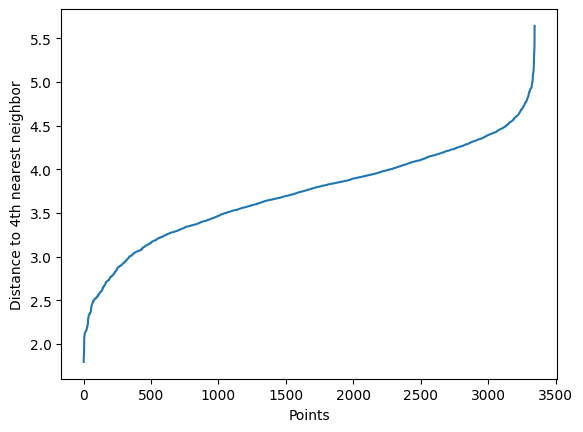

In [3]:
# Use K distance graph to determine the eps value. 
dbscan.get_kdistances(minmax_data, 4)

Based on the graph, I will choose eps = 4.5 <br>
Based on our dimensions, I will choose minPts = 231

In [4]:
# Perform dbscan algo
clusters = dbscan.perform_dbscan(minmax_data, 4.5, 231)
# Print the number of clusters
print("Number of Clusters = ",len(set(clusters)))

# Calculate silhouette avg score
silhouette_vals = silhouette_samples(minmax_data, clusters)
silhouette_avg = silhouette_score(minmax_data, clusters)
print("silhouette avg score:",silhouette_avg)

Number of Clusters =  2
silhouette avg score: 0.05812848094063399


we can't visiualize the clusters on 231 dimensions, so we need to perform dimensionality reduction. <br>
We'll determine the number of components after plotting the #features and the varience using this PCA graph. 
#### PCA Graph


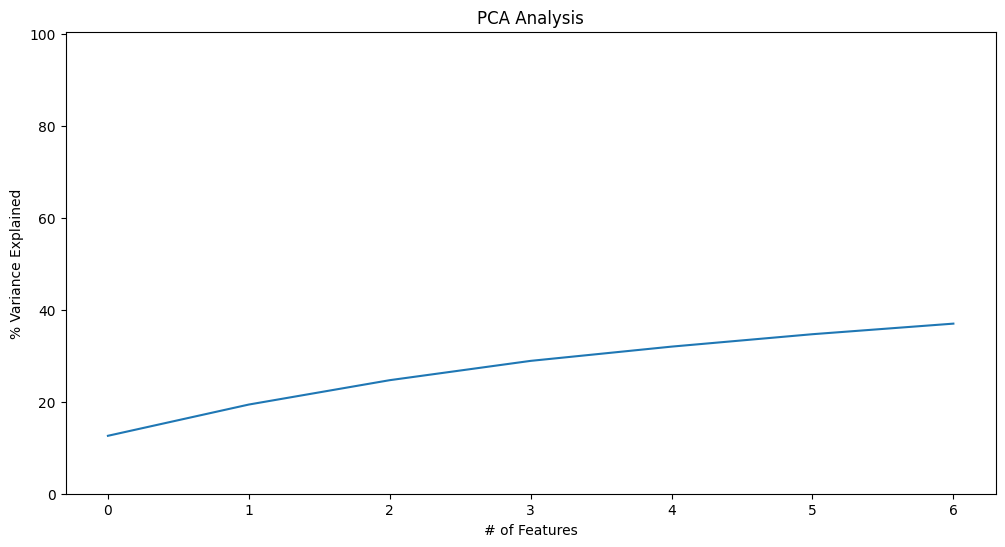

In [5]:
pca = PCA(n_components=7)
pca.fit(minmax_data)
variance = pca.explained_variance_ratio_ 
var=np.cumsum(np.round(variance, 3)*100)
plt.figure(figsize=(12,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.plot(var)
plt.show()

Based on the graph, I will try 2 and 3 Dimensions to plot the data. 

In [6]:
X_3reduced = dbscan.create_pca(minmax_data, 3)

Explained variance ratio for each component: [0.12570507 0.06839946 0.0525458 ]


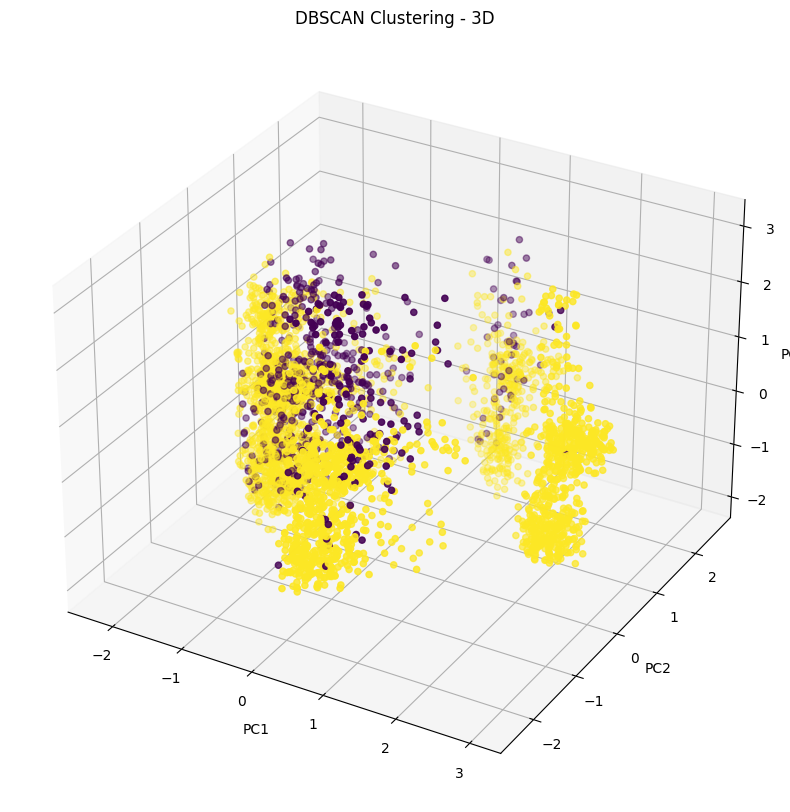

In [7]:
EDA.create_3d_scatter_plot(X_3reduced, xlabel="PC1", ylabel="PC2", zlabel="PC3", title="DBSCAN Clustering - 3D", labels=clusters)

It seems that we have different densities, and from the visualization it seems that we need more than 2 clusters. <br> let's see the 2d plot


In [8]:
# Create a PCA On 2 components. 
X_2reduced = dbscan.create_pca(minmax_data, 2)

Explained variance ratio for each component: [0.12570507 0.06839946]


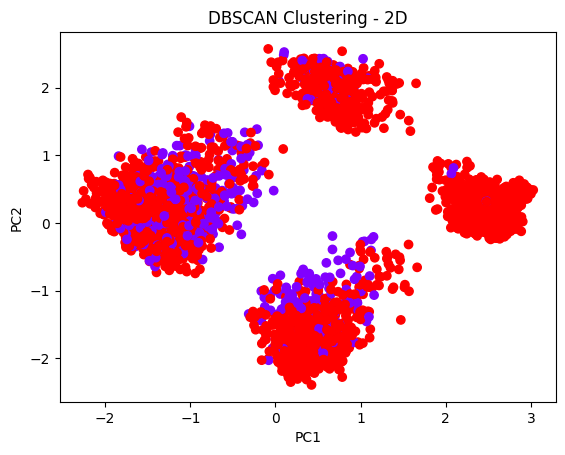

In [9]:
EDA.create_scatterplot(X_2reduced[:, 0], X_2reduced[:, 1], xlabel='PC1', ylabel='PC2', colors=clusters, title='DBSCAN Clustering - 2D')

Now we're more confident that the previous method did a bad job clustering the data. <br>
This was proved through the sillhouettee score which was 0.05812 -> far away from 1

#### 2. Different Attempts method:
we'll add a range for eps values and for minPts values, calculate the sillhouttee, and choose the best resulting model. 

In [10]:
results = dbscan.range_hyperparameters(minmax_data, [3.5, 4, 4.5, 5], [2, 3, 4, 6, 115, 200, 231, 462])
results 

eps minPts  silhouette_score n_clusters
0  3.5      2         -0.182545         78
1  3.5      3         -0.137188         19
2  3.5      4         -0.096150          7
3  3.5      6         -0.082772          4
4  4.0      2         -0.083684         10
5  4.0      3          0.003867          2
6  4.0    115         -0.021915          3

Its generally doing a bad job clustering the data, as sillhouttee scores are closer to -1. <br>
eps = 4 and minPts = 3 seems to be good with resulting 2 clusters.

## DBSCAN With 2 Dimensions 

In [11]:
# Create a PCA On 2 components. 
X_2reduced = dbscan.create_pca(minmax_data, 2)

Explained variance ratio for each component: [0.12570507 0.06839946]


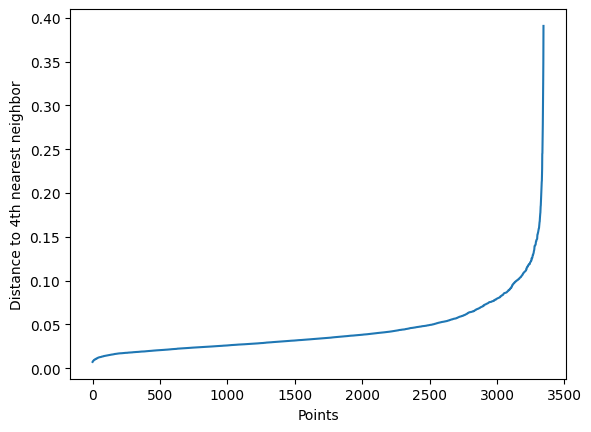

In [12]:
# Use K distance graph to determine the eps value. 
dbscan.get_kdistances(X_2reduced,4)

#### 1. Traditional Method.
Eps = 0.1, MinPts = 2*2 = 4

In [24]:
# Perform dbscan algo
clusters = dbscan.perform_dbscan(X_2reduced, 0.1, 4)
# Print the number of clusters
print("Number of Clusters = ",len(set(clusters)))

# Calculate silhouette avg score
silhouette_vals = silhouette_samples(X_2reduced, clusters)
silhouette_avg = silhouette_score(X_2reduced, clusters)
print("silhouette avg score:",silhouette_avg)

Number of Clusters =  17
silhouette avg score: 0.2459159267188608


It resulted on 17 clusters which is partially large, but it has better score than before. <br>
lets plot it.

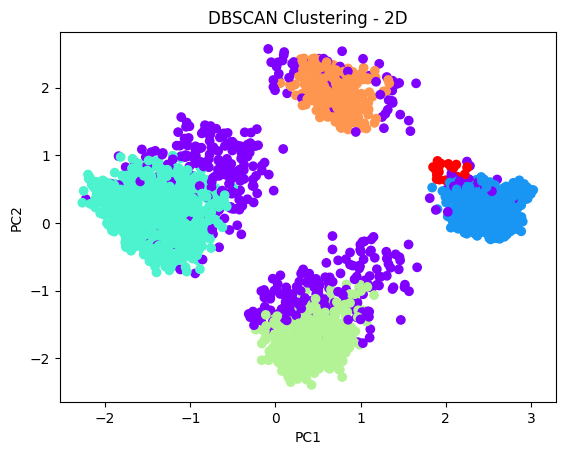

In [40]:
EDA.create_scatterplot(X_2reduced[:, 0], X_2reduced[:, 1], xlabel='PC1', ylabel='PC2', colors=clusters, title='DBSCAN Clustering - 2D')

#### 2. Different Attempts.
eps =  [0.05, 0.8, 0.1, 0.15], minPts = [2, 4, 6, 8, 10]

In [25]:
results = dbscan.range_hyperparameters(X_2reduced, [0.05, 0.8, 0.1, 0.15], [2, 4, 6, 8, 10])
results

eps minPts  silhouette_score n_clusters
0   0.05      2         -0.267944        166
1   0.05      4         -0.267525         55
2   0.05      6         -0.293328         38
3   0.05      8         -0.344600         38
4   0.05     10         -0.384071         29
5   0.10      2          0.032203         35
6   0.10      4          0.245916         16
7   0.10      6          0.314576         12
8   0.10      8          0.360964          8
9   0.10     10          0.541468          5
10  0.15      2          0.525669          7
11  0.15      4          0.535881          6
12  0.15      6          0.645839          6
13  0.15      8          0.602598          6
14  0.15     10          0.569083          6

note that eps = 0.15 produced the highest sillhouttee scores. <br> and the highest score was when with minPts values = 6 <br> Lets plot top 3 scores. Note that all of them resulted on 6 clusters.  

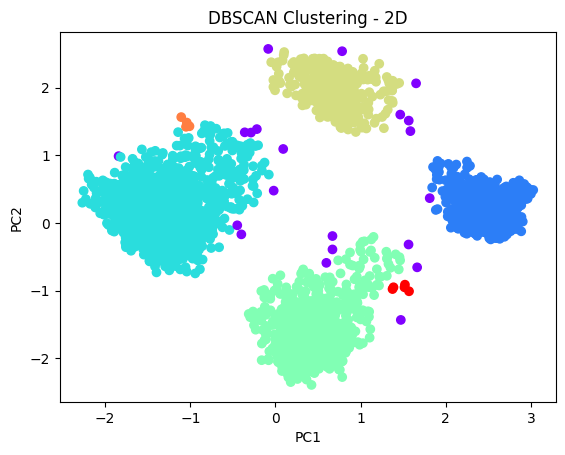

In [41]:
clusters = dbscan.perform_dbscan(X_2reduced, 0.15, 4)
EDA.create_scatterplot(X_2reduced[:, 0], X_2reduced[:, 1], xlabel='PC1', ylabel='PC2', colors=clusters, title='DBSCAN Clustering - 2D')

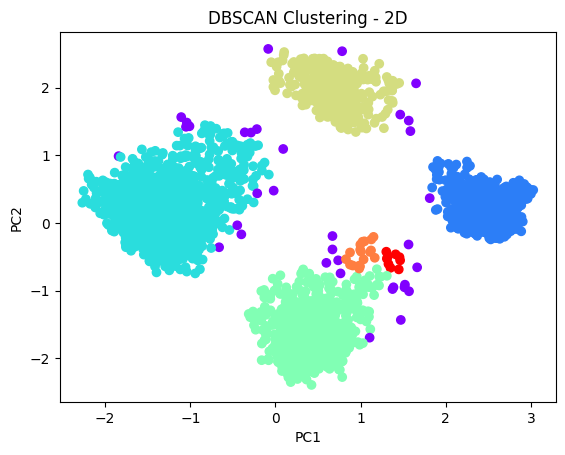

In [28]:
clusters = dbscan.perform_dbscan(X_2reduced, 0.15, 6)
EDA.create_scatterplot(X_2reduced[:, 0], X_2reduced[:, 1], xlabel='PC1', ylabel='PC2', colors=clusters, title='DBSCAN Clustering - 2D')

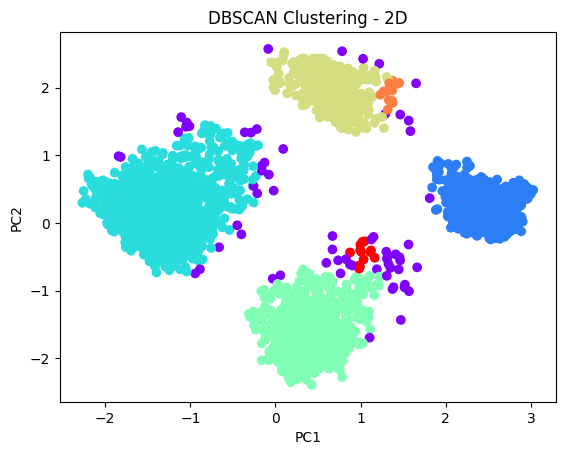

In [30]:
clusters = dbscan.perform_dbscan(X_2reduced, 0.15, 8)
EDA.create_scatterplot(X_2reduced[:, 0], X_2reduced[:, 1], xlabel='PC1', ylabel='PC2', colors=clusters, title='DBSCAN Clustering - 2D')

## DBSCAN With 3 Dimensions 

In [21]:
# Create a PCA on 3 components
X_3reduced = dbscan.create_pca(minmax_data, 3)

Explained variance ratio for each component: [0.12570507 0.06839946 0.0525458 ]


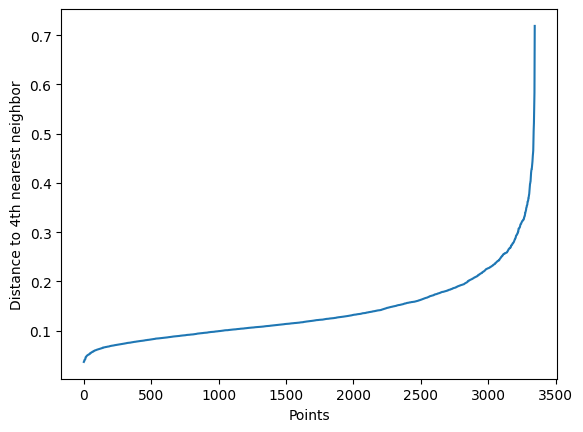

In [22]:
# Use K distance graph to determine the eps value. 
dbscan.get_kdistances(X_3reduced, 4)

#### 1. Traditional Method.
Eps = 0.25, MinPts = 3*2 = 6

In [32]:
# Perform dbscan algo
clusters = dbscan.perform_dbscan(X_3reduced, 0.25, 6)
# Print the number of clusters
print("Number of Clusters = ",len(set(clusters)))

# Calculate silhouette avg score
silhouette_vals = silhouette_samples(X_2reduced, clusters)
silhouette_avg = silhouette_score(X_2reduced, clusters)
print("silhouette avg score:",silhouette_avg)

Number of Clusters =  10
silhouette avg score: 0.3776086438779825


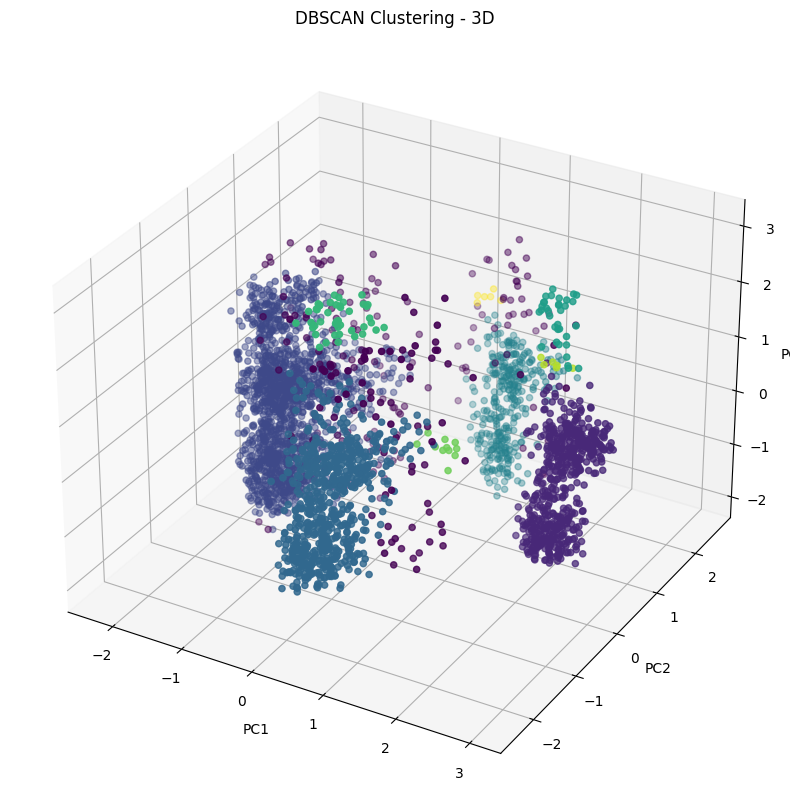

In [33]:
EDA.create_3d_scatter_plot(X_3reduced, xlabel="PC1", ylabel="PC2", zlabel="PC3", title="DBSCAN Clustering - 3D", labels=clusters)

#### 2. Different Attempts.
eps =  [.15, .2, .25, .3, .35], minPts = [3, 6, 9, 12]

In [36]:
results = dbscan.range_hyperparameters(X_3reduced, [.15, .2, .25, .3, .35], [3, 6, 9, 12])
results

eps minPts  silhouette_score n_clusters
0   0.15      3         -0.376282         62
1   0.15      6          0.001408         15
2   0.15      9         -0.012338         14
3   0.15     12         -0.354947         18
4   0.20      3         -0.107278         38
5   0.20      6          0.086909         12
6   0.20      9          0.238212          9
7   0.20     12          0.344787          5
8   0.25      3          0.028080         21
9   0.25      6          0.373740          9
10  0.25      9          0.213013          9
11  0.25     12          0.452482          5
12  0.30      3          0.350851         11
13  0.30      6          0.290534          9
14  0.30      9          0.425148          7
15  0.30     12          0.443024          7
16  0.35      3          0.389112          6
17  0.35      6          0.347099          7
18  0.35      9          0.488779          6
19  0.35     12          0.428174          8

note that eps = 0.35 , 0.3, 0.25 produced the highest sillhouttee scores. <br> and the highest score was when with minPts values either 9 or 12 <br> Lets plot top 3 scores. Note that all of them resulted on very good number of clusters (5 or 6 or 7) "better than the previous method".  

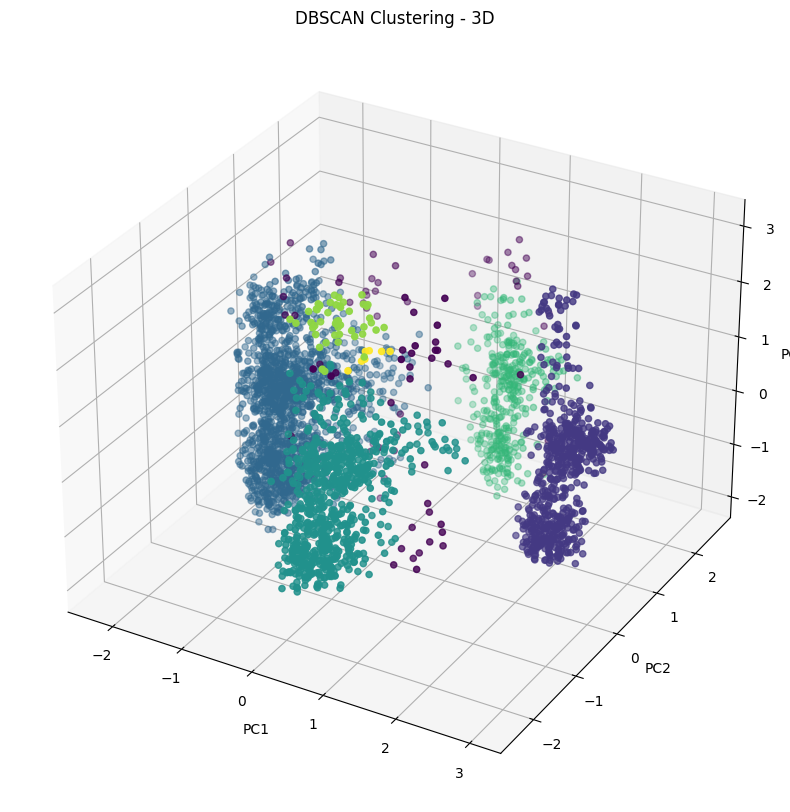

In [37]:
clusters = dbscan.perform_dbscan(X_3reduced, 0.35, 9)
EDA.create_3d_scatter_plot(X_3reduced, xlabel="PC1", ylabel="PC2", zlabel="PC3", title="DBSCAN Clustering - 3D", labels=clusters)

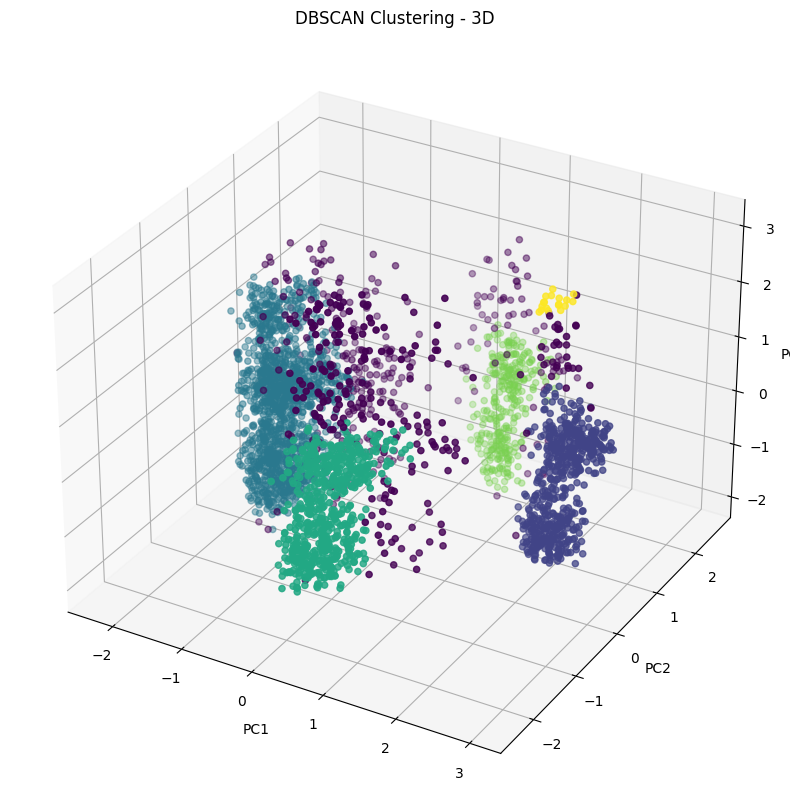

In [39]:
clusters = dbscan.perform_dbscan(X_3reduced, 0.25, 12)
EDA.create_3d_scatter_plot(X_3reduced, xlabel="PC1", ylabel="PC2", zlabel="PC3", title="DBSCAN Clustering - 3D", labels=clusters)

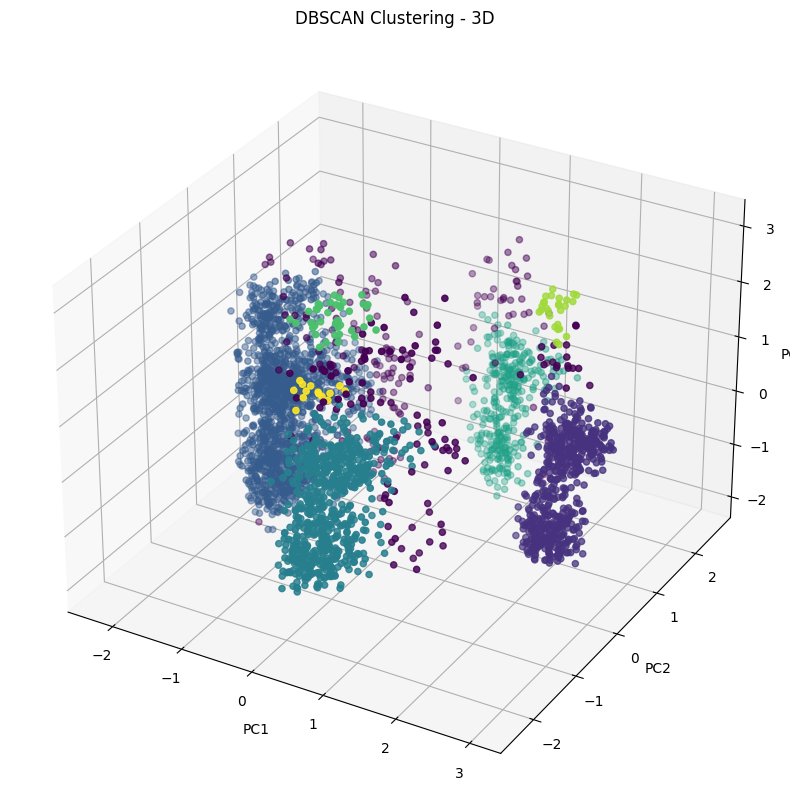

In [38]:
clusters = dbscan.perform_dbscan(X_3reduced, 0.3, 12)
EDA.create_3d_scatter_plot(X_3reduced, xlabel="PC1", ylabel="PC2", zlabel="PC3", title="DBSCAN Clustering - 3D", labels=clusters)

### Comparing the results from all models 
Plot. later

<b> Best Model is 

## Reading Standard Scaled Data

In [42]:
# Reading data 
standard_data = pd.read_csv('../data/processed/data_scaled_standard.csv')

# Print the shape of data
standard_data.shape

(3346, 231)

## DBSCAN With 231 Dimensions 
### Hyperparameters tuning: 
#### 1. Traditional method:
The traditional method chooses best eps based on the elbow from the k-distance graph. <br> best MinPts = number of dimensions or 2 * number of dimesions 

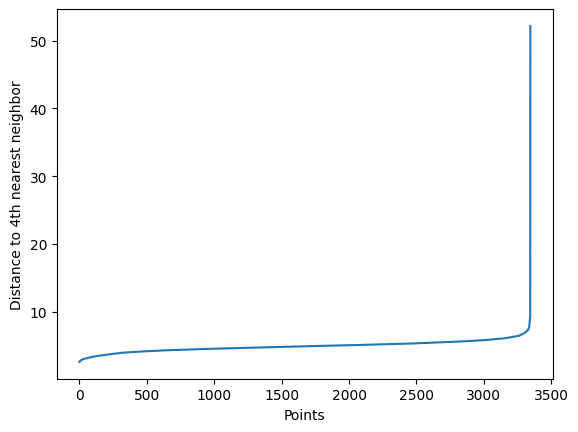

In [43]:
# Use K distance graph to determine the eps value. 
dbscan.get_kdistances(standard_data, 4)

Based on the graph, I will choose eps = 7 <br>
Based on our dimensions, I will choose minPts = 231

In [51]:
# Perform dbscan algo
clusters = dbscan.perform_dbscan(standard_data, 7, 231)
# Print the number of clusters
print("Number of Clusters = ",len(set(clusters)))

# Calculate silhouette avg score
silhouette_vals = silhouette_samples(standard_data, clusters)
silhouette_avg = silhouette_score(standard_data, clusters)
print("silhouette avg score:",silhouette_avg)

Number of Clusters =  2
silhouette avg score: 0.25130777076258015


we can't visiualize the clusters on 231 dimensions, so we need to perform dimensionality reduction. <br>
We'll determine the number of components after plotting the #features and the varience using this PCA graph. 
#### PCA Graph


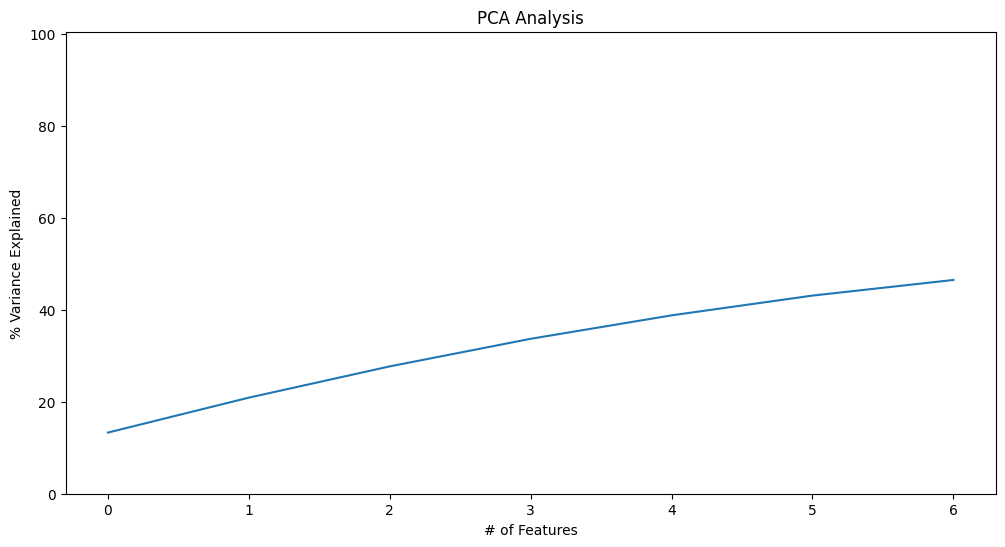

In [45]:
pca = PCA(n_components=7)
pca.fit(standard_data)
variance = pca.explained_variance_ratio_ 
var=np.cumsum(np.round(variance, 3)*100)
plt.figure(figsize=(12,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.plot(var)
plt.show()

Based on the graph, I will try 2 and 3 Dimensions to plot the data. 

In [46]:
X_3reduced = dbscan.create_pca(standard_data, 3)

Explained variance ratio for each component: [0.13291958 0.07575221 0.06823918]


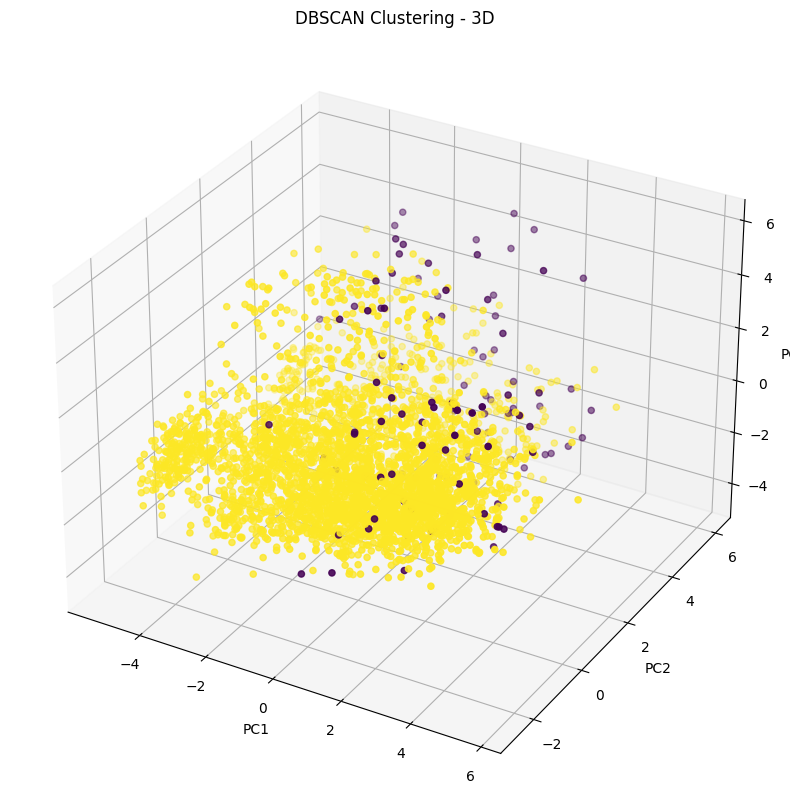

In [47]:
EDA.create_3d_scatter_plot(X_3reduced, xlabel="PC1", ylabel="PC2", zlabel="PC3", title="DBSCAN Clustering - 3D", labels=clusters)

It seems that we have density on one area more than others<br> let's see the 2d plot


In [48]:
# Create a PCA On 2 components. 
X_2reduced = dbscan.create_pca(standard_data, 2)

Explained variance ratio for each component: [0.13291958 0.07575221]


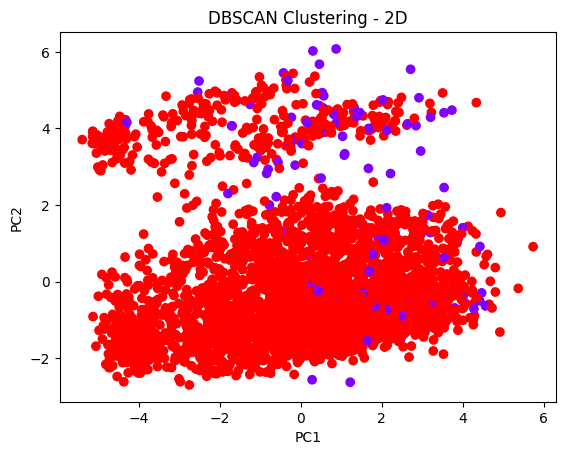

In [49]:
EDA.create_scatterplot(X_2reduced[:, 0], X_2reduced[:, 1], xlabel='PC1', ylabel='PC2', colors=clusters, title='DBSCAN Clustering - 2D')

It seems that we have two or more clusters <br>
The sillhouettee score which was 0.2513 

#### 2. Different Attempts method:
we'll add a range for eps values and for minPts values, calculate the sillhouttee, and choose the best resulting model. 

In [52]:
results = dbscan.range_hyperparameters(standard_data, [6, 6.5, 7, 7.5, 8, 8.5], [2, 3, 4, 6, 115, 200, 231, 462])
results 

eps minPts  silhouette_score n_clusters
0    6      2          0.130167          4
1  6.5      2          0.210236          2
2  6.5      3          0.210236          2
3  7.5      2          0.534094          2

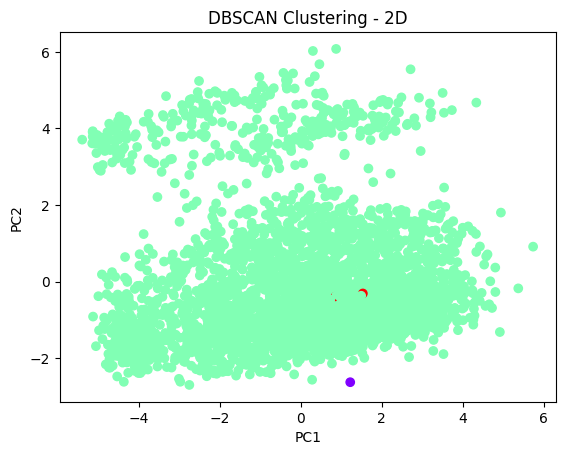

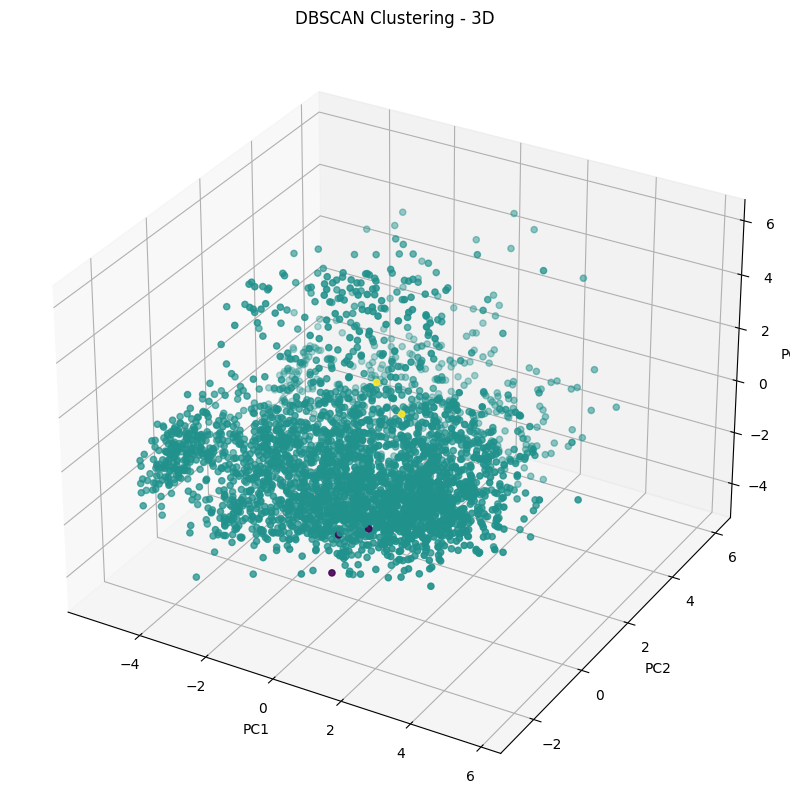

In [53]:
clusters = dbscan.perform_dbscan(standard_data, 7.5, 2)

EDA.create_scatterplot(X_2reduced[:, 0], X_2reduced[:, 1], xlabel='PC1', ylabel='PC2', colors=clusters, title='DBSCAN Clustering - 2D')

EDA.create_3d_scatter_plot(X_3reduced, xlabel="PC1", ylabel="PC2", zlabel="PC3", title="DBSCAN Clustering - 3D", labels=clusters)

Its generally doing a bad job clustering the data, even though  sillhouttee scores is good (closer to 1) <br>
but it looks like we're getting very few number of samples on a cluster and a very big number of samples on the other cluster. 

## DBSCAN With 2 Dimensions 

In [54]:
# Create a PCA On 2 components. 
X_2reduced = dbscan.create_pca(standard_data, 2)


Explained variance ratio for each component: [0.13291958 0.07575221]


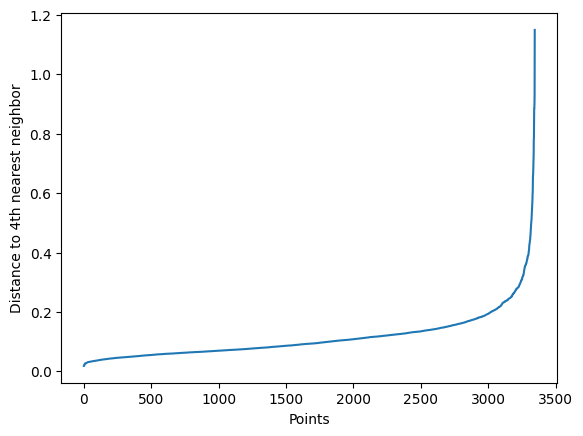

In [55]:
# Use K distance graph to determine the eps value. 
dbscan.get_kdistances(X_2reduced, 4)

#### 1. Traditional Method.
Eps = 0.25, MinPts = 2*2 = 4

In [56]:
# Perform dbscan algo
clusters = dbscan.perform_dbscan(X_2reduced, 0.25, 4)
# Print the number of clusters
print("Number of Clusters = ",len(set(clusters)))

# Calculate silhouette avg score
silhouette_vals = silhouette_samples(X_2reduced, clusters)
silhouette_avg = silhouette_score(X_2reduced, clusters)
print("silhouette avg score:",silhouette_avg)

Number of Clusters =  16
silhouette avg score: -0.020874019887024187


It resulted on 16 clusters, however the score isn't that good. (close to -1) <br>
lets plot it.

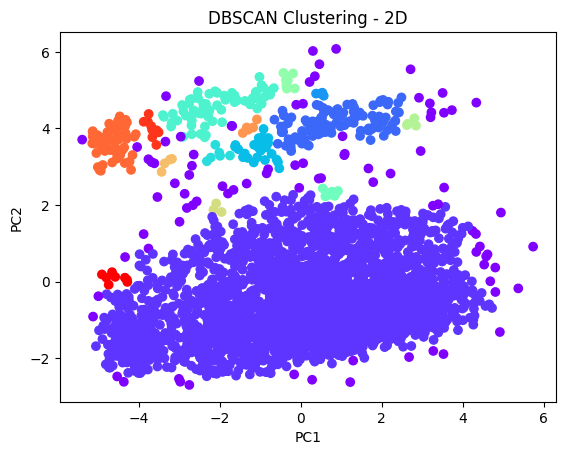

In [57]:
EDA.create_scatterplot(X_2reduced[:, 0], X_2reduced[:, 1], xlabel='PC1', ylabel='PC2', colors=clusters, title='DBSCAN Clustering - 2D')

#### 2. Different Attempts.
eps =  [0.2, 0.25, 0.3, 0.35, 0.4], minPts = [4, 6, 8, 10]

In [69]:
results = dbscan.range_hyperparameters(X_2reduced, [0.2, 0.25, 0.3, 0.35, 0.4], [4, 6, 8, 10])
results

eps minPts  silhouette_score n_clusters
0   0.20      4         -0.211420         25
1   0.20      6         -0.218218         21
2   0.20      8         -0.284761         18
3   0.20     10         -0.181139          8
4   0.25      4         -0.020874         15
5   0.25      6          0.023241         13
6   0.25      8         -0.162317         14
7   0.25     10          0.006408         11
8   0.30      4          0.129573          8
9   0.30      6          0.298243          8
10  0.30      8          0.288537          9
11  0.30     10          0.281528          8
12  0.35      4          0.304666          5
13  0.35      6          0.326005          4
14  0.35      8          0.349649          5
15  0.35     10          0.346234          5
16  0.40      4          0.186473          5
17  0.40      6          0.136205          4
18  0.40      8          0.365000          4
19  0.40     10          0.353058          5

note that eps = 0.4 or 0.35 produced the highest sillhouttee scores. <br> and the highest score was when with minPts values = 8 or 10 <br> Lets plot top 3 scores. Note that all of them resulted on 6 clusters.  

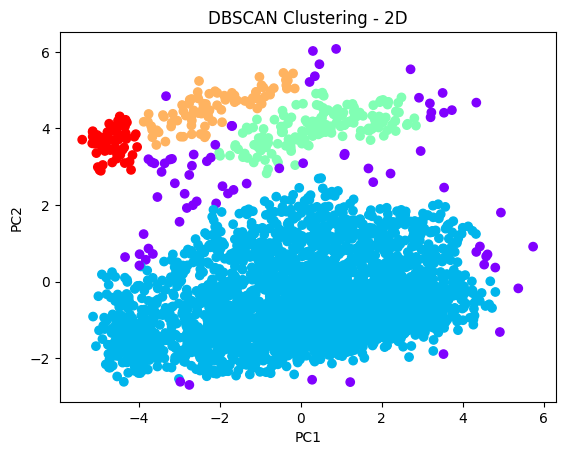

In [60]:
clusters = dbscan.perform_dbscan(X_2reduced, 0.4, 8)
EDA.create_scatterplot(X_2reduced[:, 0], X_2reduced[:, 1], xlabel='PC1', ylabel='PC2', colors=clusters, title='DBSCAN Clustering - 2D')

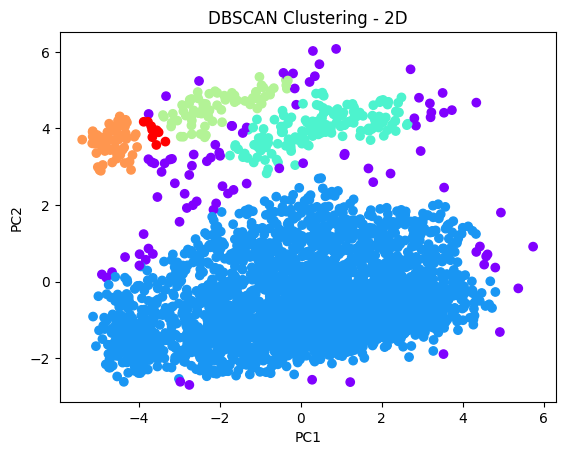

In [61]:
clusters = dbscan.perform_dbscan(X_2reduced, 0.4, 10)
EDA.create_scatterplot(X_2reduced[:, 0], X_2reduced[:, 1], xlabel='PC1', ylabel='PC2', colors=clusters, title='DBSCAN Clustering - 2D')

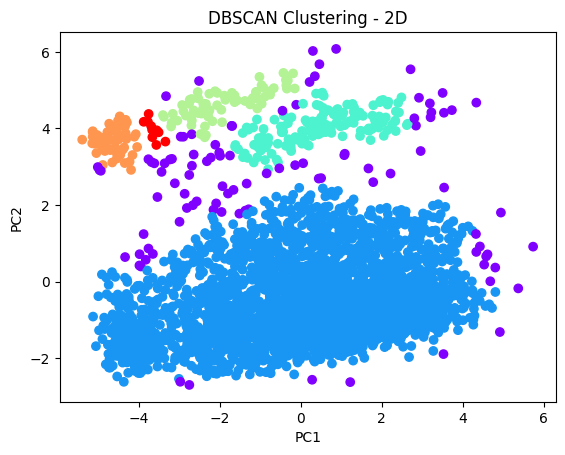

In [62]:
clusters = dbscan.perform_dbscan(X_2reduced, 0.35, 8)
EDA.create_scatterplot(X_2reduced[:, 0], X_2reduced[:, 1], xlabel='PC1', ylabel='PC2', colors=clusters, title='DBSCAN Clustering - 2D')

## DBSCAN With 3 Dimensions 

In [63]:
# Create a PCA on 3 components
X_3reduced = dbscan.create_pca(standard_data, 3)

Explained variance ratio for each component: [0.13291958 0.07575221 0.06823918]


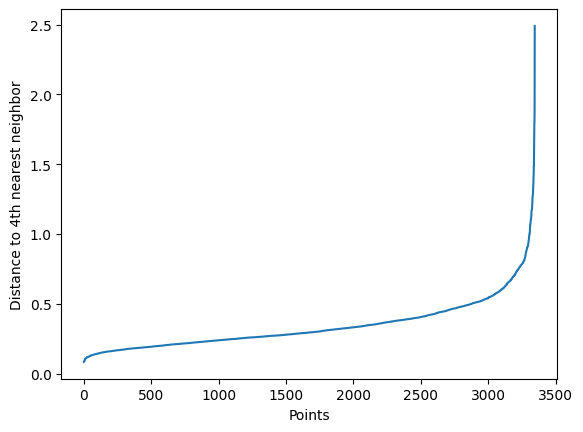

In [64]:
# Use K distance graph to determine the eps value. 
dbscan.get_kdistances(X_3reduced, 4)

#### 1. Traditional Method.
Eps = 0.7, MinPts = 3*2 = 6

In [70]:
# Perform dbscan algo
clusters = dbscan.perform_dbscan(X_3reduced, 0.7, 6)
# Print the number of clusters
print("Number of Clusters = ",len(set(clusters)))

# Calculate silhouette avg score
silhouette_vals = silhouette_samples(X_2reduced, clusters)
silhouette_avg = silhouette_score(X_2reduced, clusters)
print("silhouette avg score:",silhouette_avg)

Number of Clusters =  5
silhouette avg score: -0.0036308885271722465


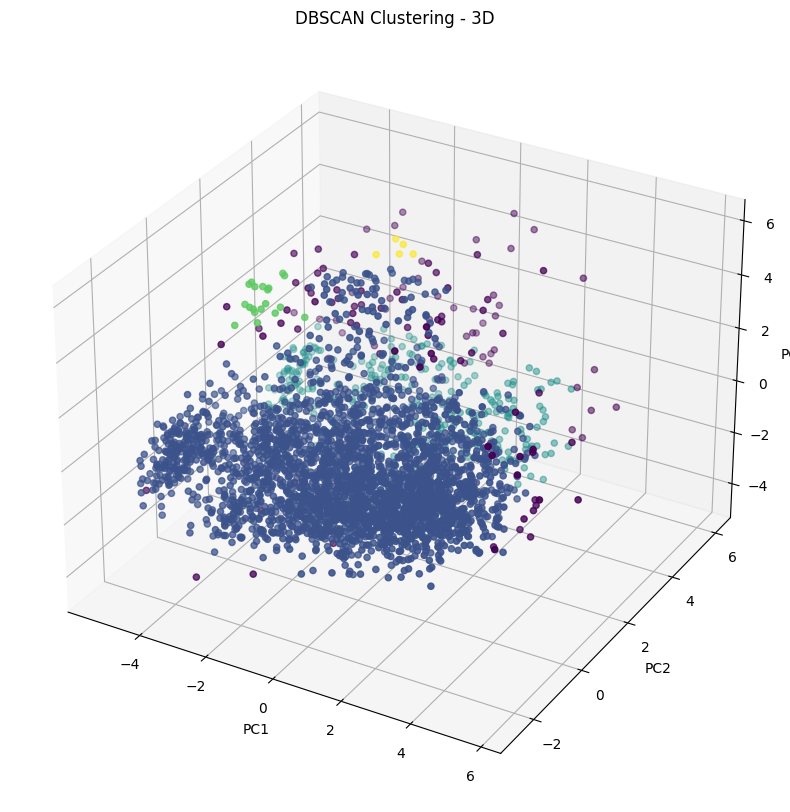

In [71]:
EDA.create_3d_scatter_plot(X_3reduced, xlabel="PC1", ylabel="PC2", zlabel="PC3", title="DBSCAN Clustering - 3D", labels=clusters)

score is very low even though #clusters seems to be very good 

#### 2. Different Attempts.
eps =  [.25, .5, .75, 1], minPts = [6, 9, 12, 15]

In [68]:
results = dbscan.range_hyperparameters(X_3reduced, [.25, .5, .75, 1], [6, 9, 12, 15])
results

eps minPts  silhouette_score n_clusters
0   0.25      6         -0.509933         53
1   0.25      9         -0.452712         17
2   0.25     12         -0.398366          8
3   0.50      6          0.025045         11
4   0.50      9         -0.216147         12
5   0.50     12         -0.276134         11
6   0.50     15         -0.066166          5
7   0.75      6          0.287532          5
8   0.75      9          0.336993          4
9   0.75     12          0.299986          5
10  0.75     15          0.271703          6
11  1.00      6          0.389861          2
12  1.00      9          0.343928          3
13  1.00     12          0.377531          2
14  1.00     15          0.375890          2

note that eps = 1 , 0.75 produced the highest sillhouttee scores. <br> and the highest score was when with minPts values either 6 or 12 <br> Lets plot top 3 scores. Note that all of them resulted on very good number of clusters (5 or 6 or 7) "better than the previous method".  

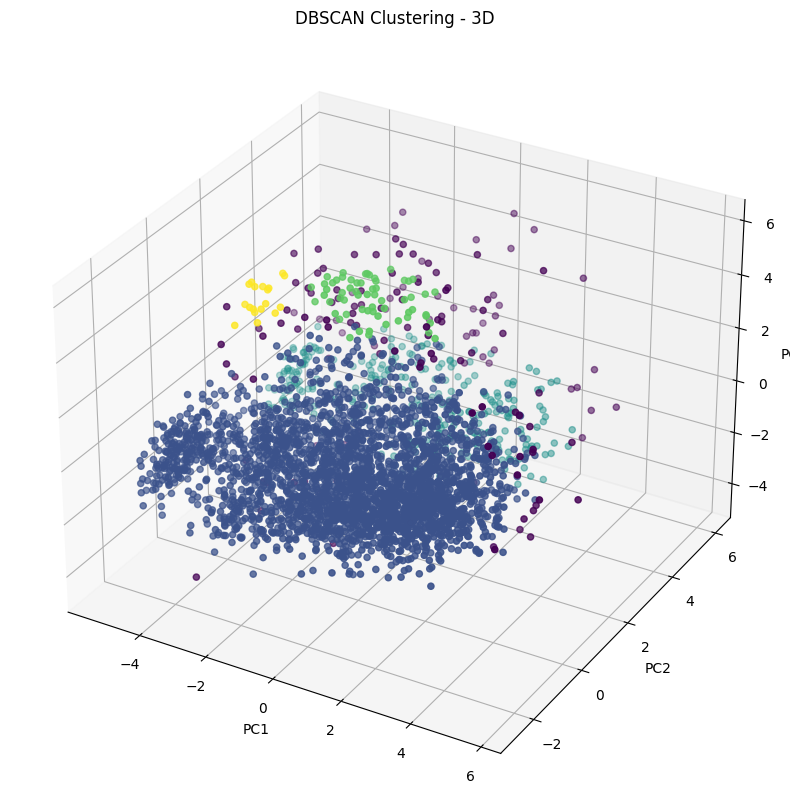

In [72]:
clusters = dbscan.perform_dbscan(X_3reduced, 0.75, 9)
EDA.create_3d_scatter_plot(X_3reduced, xlabel="PC1", ylabel="PC2", zlabel="PC3", title="DBSCAN Clustering - 3D", labels=clusters)

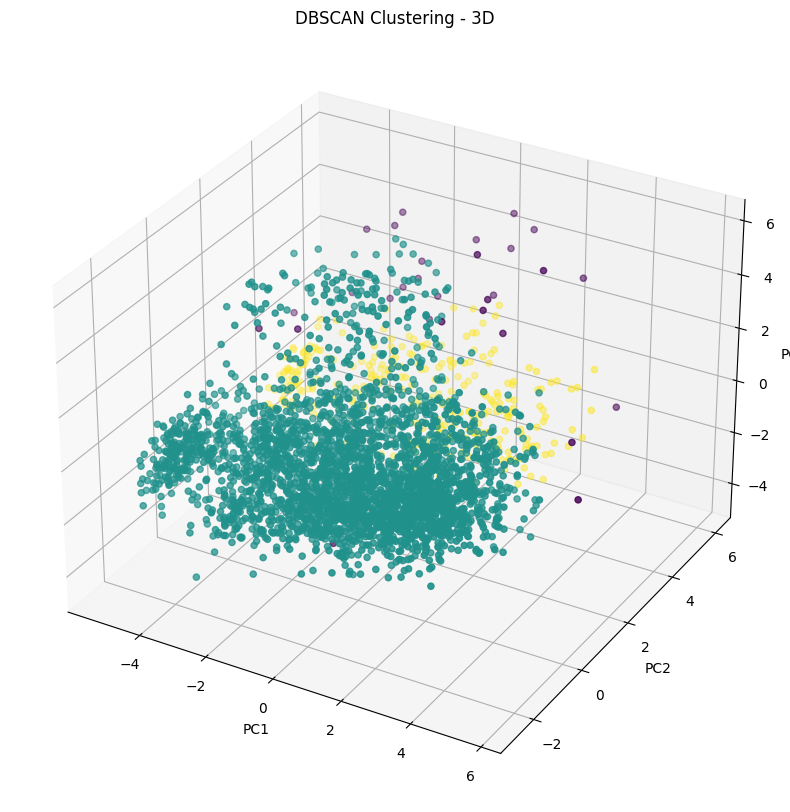

In [73]:
clusters = dbscan.perform_dbscan(X_3reduced, 1, 6)
EDA.create_3d_scatter_plot(X_3reduced, xlabel="PC1", ylabel="PC2", zlabel="PC3", title="DBSCAN Clustering - 3D", labels=clusters)

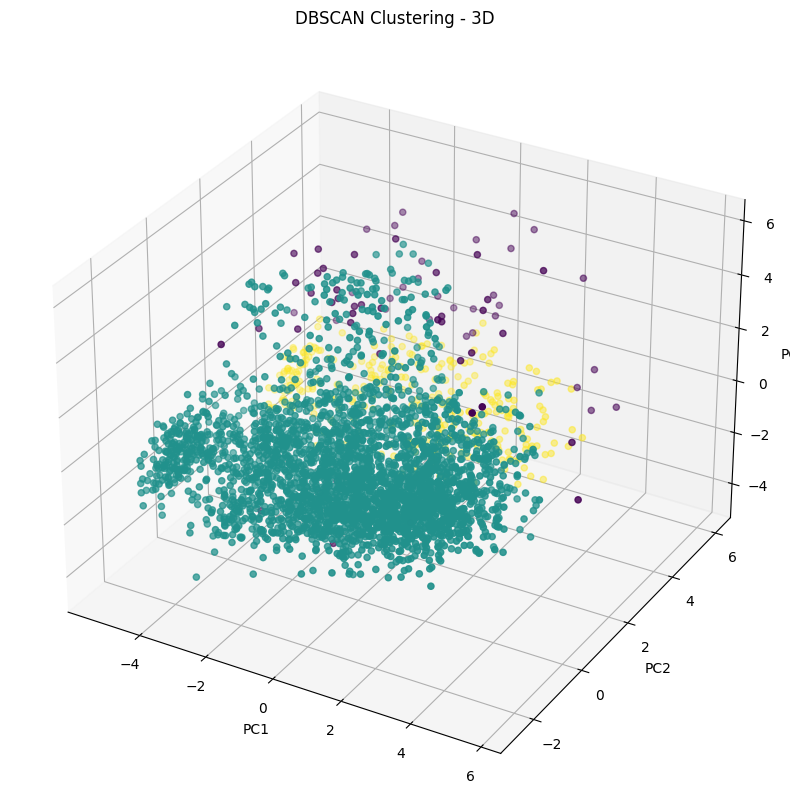

In [74]:
clusters = dbscan.perform_dbscan(X_3reduced, 1, 12)
EDA.create_3d_scatter_plot(X_3reduced, xlabel="PC1", ylabel="PC2", zlabel="PC3", title="DBSCAN Clustering - 3D", labels=clusters)